## Practice code for working with netCDF files and making maps
#### The first section of this notebook will open and manipulate a single netCDF file of 2m temperature and make a North Polar stereographic map. 
Make sure to set your kernel to the one associated with your new environment so you have all the correct packages.

In [1]:
## Import required packages
# basic packages for setting directories
import io
import os
import sys
import warnings

# to read/work with netcdf files
import xarray as xr
import netCDF4
import pandas as pd
from datetime import datetime

# for calculations and masking regions
import numpy as np
import numpy.ma as ma

# for making figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.path as mpath

# for making maps
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [2]:
## Set your workingdir to the directory where you store your jupyter notebooks
workingdir = '/Users/arielmor/Desktop/REU/notebooks/'
print("Working directory: ", workingdir)

## Set your datadir to the directory where you store your netdf files
datadir = '/Users/arielmor/Desktop/REU/data/'
print("Data directory: ", datadir)

## Set your figuredir to the directory where you want to store figures
figuredir = '/Users/arielmor/Desktop/REU/figures/'
print("Figure directory: ", figuredir)

Working directory:  /Users/arielmor/Desktop/REU/notebooks/
Data directory:  /Users/arielmor/Desktop/REU/data/
Figure directory:  /Users/arielmor/Desktop/REU/figures/


### Read in your first netcdf file

This is monthly mean 2m air temperature from one ensemble member of the CESM2 climate model, run from 2015-2064 under the SSP2-4.5 forcing scenario. It's one of the simulations we'll be using this summer :) This file has already been cropped down to ~50-90N to reduce the file size.

In [3]:
## Open the file with xarray and save it as a dataset (ds). 
# Xarray attempts to read the timestamp and return it as a YYYY-MM-DD that we can understand, 
# but sometimes that timestamp is wrong if xarray doesn't know the calendar for the data.
# If you know the frequency (e.g., monthly, daily) you can set the correct time with pandas.
ds = xr.open_dataset(datadir + '/b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h0.TREFHT.201501-206412_NH_forPractice.nc',
                    decode_times = False)
units, reference_date = ds.time.attrs['units'].split('since')
ds['time'] = pd.date_range(start=reference_date, periods=ds.sizes['time'], freq='MS') # monthly data

## Print the dataset to see variable and coordinate names.
print(ds)

<xarray.Dataset>
Dimensions:    (time: 600, lat: 44, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 49.48 50.42 51.36 52.3 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2064-12-01
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) float64 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001
    logname:           cmip6
    host:              cheyenne4
    initial_file:      b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.cam.i....
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Mon May 15 14:14:42 2023: ncks -O -d lat,49.,90. b.e21...
    NCO: 

In [4]:
## Get latitude, longitude, time, and 2m temperature
# Call variables in an xarray dataset by ds.VAR or ds['VAR']
lat = ds.lat
lon = ds.lon
time = ds.time
refHeightTemp = ds.TREFHT
ds.close() # close the dataset after reading vars to save memory

## Get decadal means for the first and last decade
Xarray is great for calculations on geophysical data because it saves coordinate information and easily creates seasonal, annual, and decadal means. Right now refHeightTemp is a 3D variable of months x latitude x longitude. We will use xarray's groupby function to group the months from each year together, average them to get an annual mean, and then average the first and last 10 years to get decadal means.

In [5]:
## Group by year and get annual mean
# Sometimes geophysical data has NaNs ('not a number'), which are missing or nonexistent data (like sea surface temperature over land). 
# We ignore NaNs when taking an average by using skipna=True
refHeightTempGrouped = refHeightTemp.groupby('time.year').mean(dim='time', skipna=True)

# Average over the first and last 10 years
refHeightTemp_20152024 = refHeightTempGrouped[:10,:,:] # first 10 timesteps, all latitudes, all longitudes
refHeightTemp_20552064 = refHeightTempGrouped[-10:,:,:] # last 10 timesteps, all latitudes, all longitudes

print("Years should be 2015 - 2024: ", refHeightTemp_20152024.year)
print("Years should be 2055 - 2064: ", refHeightTemp_20552064.year)

# Decadal means
refHeightTempMean_20152024 = refHeightTemp_20152024.mean(dim='year', skipna=True)
refHeightTempMean_20552064 = refHeightTemp_20552064.mean(dim='year', skipna=True)

Years should be 2015 - 2024:  <xarray.DataArray 'year' (year: 10)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
Years should be 2055 - 2064:  <xarray.DataArray 'year' (year: 10)>
array([2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064])
Coordinates:
  * year     (year) int64 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064


In [6]:
## Difference between first and last decade
refHeightTempDiff = refHeightTempMean_20552064 - refHeightTempMean_20152024
print(refHeightTempDiff.shape) # check that the difference is the shape of lat x lon

(44, 288)


#### Plot the decadal difference on a North Polar stereographic map
There are lots of map projections, but we'll almost always use polar stereographic because we're looking at Arctic data.
Below is the function that I always use to make Arctic maps. Functions are the best way to make maps because it keeps your code neat and prevents a lot of copy-pasting.

Inputs:
- var = variable to be plotted
- latitude, longitude = lat, lon
- vmins, vmaxs = minimum and maximum values of data
- mycmap = colormap (https://matplotlib.org/stable/tutorials/colors/colormaps.html --> 'RdBu_r' is a good choice for temperature differences)
- label = label for colorbar (units of data)
- title = figure title
- savetitle = file name for saved figure

In [7]:
def make_maps(var,latitude,longitude,vmins,vmaxs,mycmap,label,title,savetitle):
    # Add cyclic point
    var,lon = add_cyclic_point(var,coord=longitude)
    
    # Create figure
    fig = plt.figure(figsize=(12,8))
    if vmins < 0. and vmins > 0.:
        norm = mcolors.TwoSlopeNorm(vmin=vmins, vcenter=0, vmax=vmaxs)
    else:
        norm = mcolors.Normalize(vmin=vmins, vmax=vmaxs)
        
    # Create North Pole Stereo projection map, circle boundary
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([180, -180, 50, 90], crs=ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_facecolor('0.94')
    
    cf1 = ax.pcolormesh(lon,latitude,var,transform=ccrs.PlateCarree(), 
                  norm=norm, cmap=mycmap)
    ax.coastlines(linewidth=0.8)
    if vmins < 0.:
        cbar = plt.colorbar(cf1, ax=ax, extend="both")
    else:
        cbar = plt.colorbar(cf1, ax=ax, extend="max")
    cbar.set_label(str(label), fontsize=12)
    plt.title(str(title), fontsize=13)
    plt.savefig(figuredir + str(savetitle) + '.jpg', dpi=1000, bbox_inches='tight')
    return fig, ax

-1.5552979 4.0786133


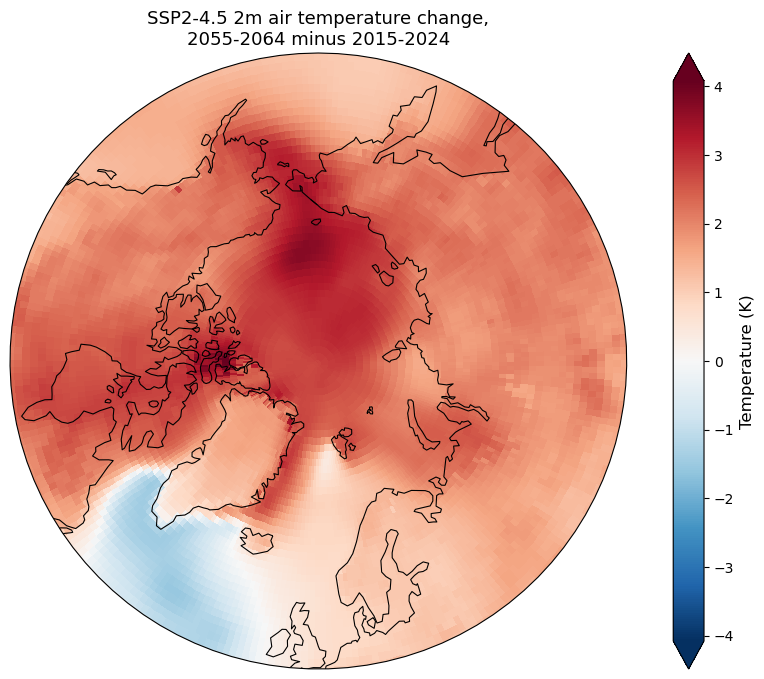

In [8]:
## The map function requires the data's min/max value
vmin = np.nanmin(refHeightTempDiff)
vmax = np.nanmax(refHeightTempDiff)
print(vmin, vmax)

# To get a nice colorbar, vmin and vmax should be negative and positive values of the same number
if np.abs(vmin) > vmax: vmax = np.abs(vmin)
elif vmax > np.abs(vmin): vmin = vmax*(-1)

warnings.simplefilter("ignore")
fig, ax = make_maps(refHeightTempDiff,lat,lon,vmin,vmax,'RdBu_r','Temperature (K)','SSP2-4.5 2m air temperature change,\n2055-2064 minus 2015-2024',
           'ssp245_ens1_2m_temp_change_20552064-20152024')